In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import torchvision
from sklearn.metrics import confusion_matrix
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import pandas as pd
import PIL
import seaborn as sn
from tqdm import tqdm
import random
import sys
import os
import json
import math
import matplotlib.pyplot as plot

from AOI_study_certify import get_test_loader
sys.path.append('./PatchGuard')
import nets.dsresnet_cifar as resnet
from utils.defense_utils import *
cudnn.benchmark = True
device = 'cuda' if torch.cuda.is_available() else 'cpu'

## load the data

In [2]:
vit_result =  [
    "../save/output/save/vit_b16_cifar_mask64_verify_resize32",
    "../save/output/save/vit_b16_cifar_mask64_verify_resize28",
    "../save/output/save/vit_b16_cifar_mask64_verify_resize26",
    "../save/output/save/vit_b16_cifar_mask64_verify_resize24",
    "../save/output/save/vit_b16_cifar_mask64_verify_resize22",
    "../save/output/save/vit_b16_cifar_mask64_verify_resize20",
    #"../save/output/save/vit_b16_cifar_mask64_verify_resize14"
]

In [3]:
patch_smooth_result = [
    "result/band4_32_ps_5.pt",
    "result/band4_28_ps_5.pt",
    "result/band4_26_ps_5.pt",
    "result/band4_24_ps_5.pt",
    "result/band4_22_ps_5.pt",
    "result/band4_20_ps_5.pt",
    #"result/band4_14_ps_5.pt"
]

In [4]:
patch_guard_bd_result = [
    "result/band4_32_pg_5.pt",
    "result/band4_28_pg_5.pt",
    "result/band4_26_pg_5.pt",
    "result/band4_24_pg_5.pt",
    "result/band4_22_pg_5.pt",
    "result/band4_20_pg_5.pt",
    #"result/band4_14_pg_5.pt",
]

In [5]:
patch_guard_bag_result = [
    "result/bagnet17_32_pg_30.pt",
    "result/bagnet17_28_pg_30.pt",
    "result/bagnet17_26_pg_30.pt",
    "result/bagnet17_24_pg_30.pt",
    "result/bagnet17_22_pg_30.pt",
    "result/bagnet17_20_pg_30.pt",
    #"result/bagnet17_14_pg_30.pt"
]

In [6]:
class_ = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [8]:
resize_idx = [32, 28, 26, 24, 22, 20]
x_ticks = [32- 2 * i for i in range(7)]

In [9]:
vit_result_dict = dict()
for i, idx in enumerate(resize_idx):
    temp = torch.load(os.path.join(vit_result[i], "result.pt"))
    vit_result_dict[idx] = temp

In [10]:
result = torch.unique(vit_result_dict[20]['preds_list'][1], return_counts=True)

In [11]:
for idx in vit_result_dict:
    predictions_all_list = list() 
    for value in vit_result_dict[idx]['preds_list']:
        result = torch.unique(value.cpu(), return_counts=True)
        temp = torch.zeros(10, dtype=torch.int64).scatter(0, result[0], result[1])
        predictions_all_list.append(temp)
    vit_result_dict[idx]['predictions_all_list'] = predictions_all_list

In [12]:
patch_smooth_result_dict = dict()
for i, idx in enumerate(resize_idx):
    temp = torch.load(patch_smooth_result[i])
    patch_smooth_result_dict[idx] = temp

In [13]:
patch_guard_bd_result_dict = dict()
for i, idx in enumerate(resize_idx):
    temp = torch.load(patch_guard_bd_result[i])
    patch_guard_bd_result_dict[idx] = temp

In [14]:
patch_guard_bag_result_dict = dict()
for i, idx in enumerate(resize_idx):
    temp = torch.load(patch_guard_bag_result[i])
    patch_guard_bag_result_dict[idx] = temp

## statistics

In [ ]:
# verified_ratio
# accuracy
# accuracy_in_verified

In [ ]:
# correct_proportion
# cert_proportion
# cert_correct_proportion

In [25]:
patch_smooth_result_dict[idx]

{'correct_proportion': 67.35,
 'cert_correct_proportion': 1.03,
 'cert_wrong_proportion': 0.21,
 'cert_proportion': 1.24,
 'clean_corr_index': tensor([ True, False,  True,  ..., False,  True,  True]),
 'wrong_index': tensor([False,  True, False,  ...,  True, False, False]),
 'certified_index': tensor([ True, False, False,  ..., False, False, False]),
 'predictions_all_list': tensor([[ 4.,  0.,  0.,  ...,  2.,  0.,  0.],
         [ 3., 11.,  0.,  ...,  3., 10.,  1.],
         [ 4.,  6.,  0.,  ...,  3., 19.,  2.],
         ...,
         [ 0.,  0.,  8.,  ...,  7.,  0.,  0.],
         [ 8., 16.,  3.,  ...,  4.,  0.,  0.],
         [ 0.,  0.,  1.,  ..., 24.,  0.,  0.]])}

In [16]:
for i, idx in enumerate(resize_idx):
    print("===={}====".format(idx))
    acc1 = vit_result_dict[idx]['accuracy']
    acc2 = patch_guard_bd_result_dict[idx]['correct_proportion']
    acc3 = patch_smooth_result_dict[idx]['correct_proportion']
    print("Accuracy for model: vit: {}, patch_guard: {} patch_smooth: {}".format(acc1, acc2, acc3))
    verified_ratio1 = vit_result_dict[idx]['verified_accuracy']
    verified_ratio2 = patch_guard_bd_result_dict[idx]['cert_correct_proportion']
    verified_ratio3 = patch_smooth_result_dict[idx]['cert_correct_proportion']
    print("Verified accuracy for model: vit: {}, patch_guard: {} patch_smooth: {}".format(verified_ratio1, verified_ratio2, verified_ratio3))
    verified_acc1 = np.round(vit_result_dict[idx]['accuracy_in_verified'], 2)
    verified_acc2 = patch_guard_bd_result_dict[idx]['cert_correct_proportion'] * 100 / patch_guard_bd_result_dict[idx]['cert_proportion']
    verified_acc2 = round(verified_acc2, 2)
    verified_acc3 = patch_smooth_result_dict[idx]['cert_correct_proportion'] * 100 / patch_smooth_result_dict[idx]['cert_proportion']
    verified_acc3 = round(verified_acc3, 2)
    print("Accuracy in verified for model: vit: {}, patch_guard: {} patch_smooth: {}".format(verified_acc1, verified_acc2, verified_acc3))

====32====
Accuracy for model: vit: 98.8, patch_guard: 0.835 patch_smooth: 83.35
Verified accuracy for model: vit: 88.85, patch_guard: 0.5323 patch_smooth: 51.85
Accuracy in verified for model: vit: 99.83, patch_guard: 97.87 patch_smooth: 97.08
====28====
Accuracy for model: vit: 98.3, patch_guard: 0.808 patch_smooth: 80.29
Verified accuracy for model: vit: 84.48, patch_guard: 0.4466 patch_smooth: 42.19
Accuracy in verified for model: vit: 99.85, patch_guard: 96.92 patch_smooth: 97.06
====26====
Accuracy for model: vit: 97.81, patch_guard: 0.7747 patch_smooth: 77.65
Verified accuracy for model: vit: 80.44, patch_guard: 0.3824 patch_smooth: 35.94
Accuracy in verified for model: vit: 99.79, patch_guard: 96.3 patch_smooth: 96.43
====24====
Accuracy for model: vit: 97.79, patch_guard: 0.7705 patch_smooth: 76.85
Verified accuracy for model: vit: 77.94, patch_guard: 0.3321 patch_smooth: 30.96
Accuracy in verified for model: vit: 99.76, patch_guard: 93.79 patch_smooth: 96.99
====22====
Accura

## certified accuracy drop

In [17]:
vit_verified_certified_acc = [vit_result_dict[idx]['verified_accuracy'] for idx in vit_result_dict]
patch_smooth_band_certified_acc = [patch_smooth_result_dict[idx]['cert_correct_proportion'] for idx in patch_smooth_result_dict]
patch_guard_bd_certified_acc = [patch_guard_bd_result_dict[idx]['cert_correct_proportion'] * 100 for idx in patch_guard_bd_result_dict]
patch_guard_bag_certified_acc = [patch_guard_bag_result_dict[idx]['cert_correct_proportion'] * 100 for idx in patch_guard_bag_result_dict]

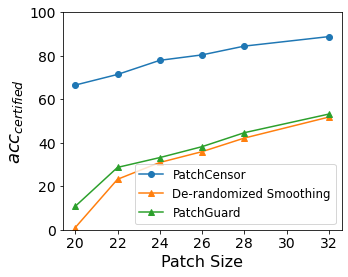

In [18]:
fig, (ax1) = plt.subplots(1, 1, figsize=(5, 4))
ax1.plot(resize_idx, vit_verified_certified_acc, marker='o', label='PatchCensor')
ax1.plot(resize_idx, patch_smooth_band_certified_acc, marker='^', label="De-randomized Smoothing")
ax1.plot(resize_idx, np.array(patch_guard_bd_certified_acc), marker='^', label="PatchGuard")
#ax1.plot(resize_idx, np.array(patch_guard_bag_certified_acc))
ax1.set_ylim([0, 100])
ax1.set_xticks(x_ticks)
ax1.xaxis.set_tick_params(labelsize=14)
ax1.yaxis.set_tick_params(labelsize=14)
ax1.legend(loc="lower right", fontsize=11.8)
ax1.set_xlabel("Patch Size", fontsize=16)
ax1.set_ylabel("$acc_{certified}$", fontsize=18)
fig.savefig("resize_certified_acc.pdf", dpi=300, bbox_inches='tight')

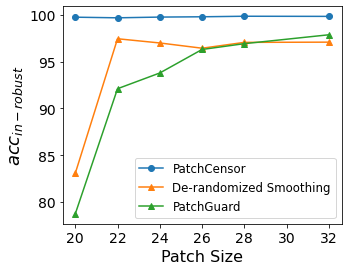

In [19]:
vit_verified_cer_error_ratio = [vit_result_dict[idx]['accuracy_in_verified'] for idx in vit_result_dict]
patch_smooth_band_cer_error_ratio = [patch_smooth_result_dict[idx]['cert_correct_proportion'] * 100 / patch_smooth_result_dict[idx]['cert_proportion']
                                     for idx in patch_smooth_result_dict]
patch_guard_bd_cer_error_ratio = [patch_guard_bd_result_dict[idx]['cert_correct_proportion'] * 100 / patch_guard_bd_result_dict[idx]['cert_proportion']
                                  for idx in patch_guard_bd_result_dict]
patch_guard_bag_cer_error_ratio = [patch_guard_bag_result_dict[idx]['cert_correct_proportion'] * 100 / patch_guard_bag_result_dict[idx]['cert_proportion']
                                   for idx in patch_guard_bag_result_dict]

fig, (ax1) = plt.subplots(1, 1, figsize=(5, 4))
ax1.plot(resize_idx, vit_verified_cer_error_ratio, marker='o', label='PatchCensor')
ax1.plot(resize_idx, patch_smooth_band_cer_error_ratio, marker='^', label="De-randomized Smoothing")
ax1.plot(resize_idx, patch_guard_bd_cer_error_ratio, marker='^', label="PatchGuard")
#ax1.plot(resize_idx, patch_guard_bag_cer_error_ratio)
#ax1.set_ylim([40, 100])
ax1.set_xticks(x_ticks)
ax1.xaxis.set_tick_params(labelsize=14)
ax1.yaxis.set_tick_params(labelsize=14)
ax1.legend(loc="lower right", fontsize=11.8)
ax1.set_xlabel("Patch Size", fontsize=16)
ax1.set_ylabel("$acc_{in-robust}$", fontsize=18)
fig.savefig("resize_acc_in_trust.pdf", dpi=300, bbox_inches='tight')

In [19]:
resize_key = [32, 28, 26]
#resize_key = [24, 22, 20]

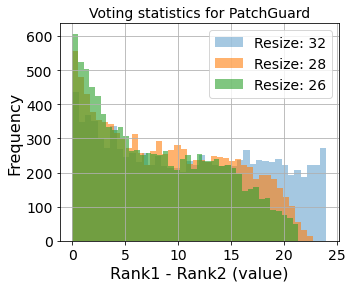

In [20]:
predictions_all_list_32 = patch_guard_bd_result_dict[resize_key[0]]['predictions_all_list']
predictions_all_list_22 = patch_guard_bd_result_dict[resize_key[1]]['predictions_all_list']
predictions_all_list_20 = patch_guard_bd_result_dict[resize_key[2]]['predictions_all_list']
fig, (ax1) = plt.subplots(1, 1, figsize=(5, 4))
resize = 20
temp_sort = torch.sort(predictions_all_list_32, dim=1)[0]
df = pd.DataFrame({"value":(temp_sort[:, -1] - temp_sort[:, -2]).numpy()})
df.hist(bins=40, ax=ax1, alpha=0.4, label="Resize: {}".format(resize_key[0]))
temp_sort = torch.sort(predictions_all_list_22, dim=1)[0]
df = pd.DataFrame({"value":(temp_sort[:, -1] - temp_sort[:, -2]).numpy()})
df.hist(bins=40, ax=ax1, alpha=0.6, label="Resize: {}".format(resize_key[1]))
temp_sort = torch.sort(predictions_all_list_20, dim=1)[0]
df = pd.DataFrame({"value":(temp_sort[:, -1] - temp_sort[:, -2]).numpy()})
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
df.hist(bins=40, ax=ax1, alpha=0.6, label="Resize: {}".format(resize_key[2]))
plt.xlabel("Rank1 - Rank2 (value)", fontsize=16)
plt.ylabel("Frequency", fontsize=16)
plt.title("Voting statistics for PatchGuard", fontsize=14)
plt.legend(fontsize=14)
fig.savefig("resize_patchGuard_voting_32.jpg", dpi=300, bbox_inches='tight')

In [23]:
resize_key = [32, 28, 26]
#resize_key = [24, 22, 20]

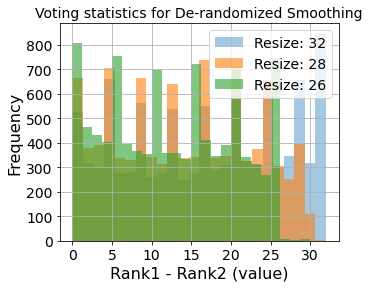

In [24]:
predictions_all_list_32 = patch_smooth_result_dict[resize_key[0]]['predictions_all_list']
predictions_all_list_22 = patch_smooth_result_dict[resize_key[1]]['predictions_all_list']
predictions_all_list_20 = patch_smooth_result_dict[resize_key[2]]['predictions_all_list']
fig, (ax1) = plt.subplots(1, 1, figsize=(5, 4))
resize = 20
bins = 24
temp_sort = torch.sort(predictions_all_list_32, dim=1)[0]
df = pd.DataFrame({"value":(temp_sort[:, -1] - temp_sort[:, -2]).numpy()})
df.hist(bins=bins, ax=ax1, alpha=0.4, label="Resize: {}".format(resize_key[0]))
temp_sort = torch.sort(predictions_all_list_22, dim=1)[0]
df = pd.DataFrame({"value":(temp_sort[:, -1] - temp_sort[:, -2]).numpy()})
df.hist(bins=bins, ax=ax1, alpha=0.6, label="Resize: {}".format(resize_key[1]))
temp_sort = torch.sort(predictions_all_list_20, dim=1)[0]
df = pd.DataFrame({"value":(temp_sort[:, -1] - temp_sort[:, -2]).numpy()})
df.hist(bins=bins, ax=ax1, alpha=0.6, label="Resize: {}".format(resize_key[2]))
plt.xlabel("Rank1 - Rank2 (value)", fontsize=16)
plt.ylabel("Frequency", fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title("Voting statistics for De-randomized Smoothing", fontsize=14)
plt.legend(fontsize=14, loc="upper right")
#fig.savefig("certified_accuracy.pdf", dpi=300, bbox_inches='tight')
fig.savefig("resize_patchSmoothing_voting_32.jpg", dpi=300, bbox_inches='tight')

In [215]:
test_loader = get_test_loader("resnet", 32, 1)

/home/malei/.local/lib/python3.8/site-packages/torchvision/transforms/transforms.py:280: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  warnings.warn(


Files already downloaded and verified


In [216]:
dataset_path = "../dataset"

In [557]:
transform_test = transforms.Compose([
    transforms.ToTensor(),
])
testset = torchvision.datasets.CIFAR10(root=dataset_path, train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=1, shuffle=False)
img_list = list()
img_label = list()
for img, label in testloader:
    img_list.append(img)
    img_label.append(label)
img_list = torch.cat(img_list)
img_label = torch.cat(img_label)
original_image = img_list[3000].permute(1, 2, 0)

padding_size = (32 - 20) // 2
transform_test = transforms.Compose([
    transforms.Resize((20, 20), PIL.Image.BICUBIC),
    transforms.Pad(padding_size, padding_size),
    transforms.ToTensor(),
    # transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])
testset = torchvision.datasets.CIFAR10(root=dataset_path, train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=1, shuffle=False)
img_list = list()
img_label = list()
for img, label in testloader:
    img_list.append(img)
    img_label.append(label)
img_list = torch.cat(img_list)
img_label = torch.cat(img_label)
resize_image = img_list[3000].permute(1, 2, 0)

Files already downloaded and verified
Files already downloaded and verified


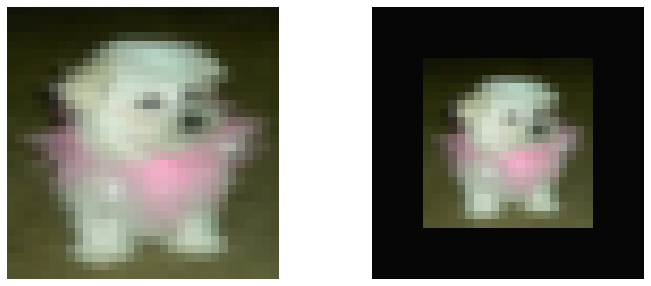

In [566]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
ax1.imshow(original_image, cmap='gray')
ax1.axis('off')
ax2.imshow(resize_image, cmap='gray')
ax2.axis('off')
fig.savefig("Resize_illustration.pdf", dpi=300, bbox_inches='tight')

In [22]:
ax_list[0][0].imshow(example_a.permute(1, 2, 0), cmap='gray')
ax_list[0][1].imshow(example_b.permute(1, 2, 0), cmap='gray')

mask_example_9 = torch.zeros_like(example_a)
mask_example_9[:, :, pos:pos+block_size] = example_a[:, :, pos:pos+block_size]
mask_example_b = torch.zeros_like(example_b)

NameError: name 'example_a' is not defined

In [21]:
class_ = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
certification_diff_dict = dict()
certification_diff_dict["class"] = class_
cases,cnt = np.unique(img_label, return_counts=True)
certification_diff_dict['# of instance'] = cnt
cases,cnt = np.unique(img_label[certified_index.type(torch.bool)], return_counts=True)
certification_diff_dict['# of certified instance'] = cnt
cases, cnt = np.unique(img_label[clean_corr_index.type(torch.bool)], return_counts=True)
certification_diff_dict['# of correct instance'] = cnt
cases, cnt = np.unique(img_label[~certified_index.type(torch.bool) & clean_corr_index.type(torch.bool)], return_counts=True)
certification_diff_dict['# of correct but not certified instance'] = cnt

NameError: name 'img_label' is not defined

## confusion matrix

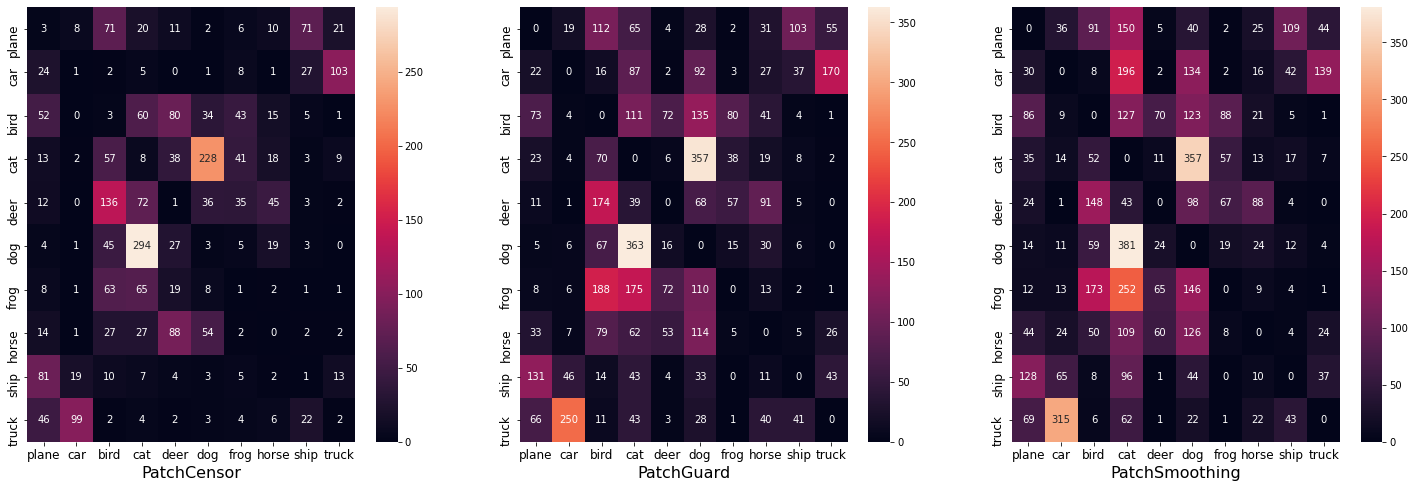

In [61]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(25, 8))
predictions_all_list = torch.stack(vit_result_dict[22]['predictions_all_list']).numpy()
certified_index = torch.tensor(vit_result_dict[22]['certified_index']).reshape(-1)
clean_corr_index = torch.tensor(vit_result_dict[22]['clean_corr_index']).reshape(-1)
index = (~certified_index & clean_corr_index).to(torch.bool)
cmatrix = confusion_matrix(img_label[index].numpy(), np.argsort(-predictions_all_list[index], axis=1, kind='stable')[:, 1])
df_cm = pd.DataFrame(cmatrix, index = [class_[i] for i in range(10)],
                  columns = [class_[i] for i in range(10)])
sn.heatmap(df_cm, annot=True, fmt='.3g', ax=ax1, label="PatchCensor")
ax1.set_xlabel("PatchCensor", fontsize=16)
ax1.tick_params(labelsize=12)

predictions_all_list = patch_guard_bd_result_dict[22]['predictions_all_list']
certified_index = patch_guard_bd_result_dict[22]['certified_index']
clean_corr_index = patch_guard_bd_result_dict[22]['clean_corr_index']
index = ~certified_index & clean_corr_index
cmatrix = confusion_matrix(img_label[index].numpy(), np.argsort(-predictions_all_list[index].numpy(), axis=1, kind='stable')[:, 1])
df_cm = pd.DataFrame(cmatrix, index = [class_[i] for i in range(10)],
                  columns = [class_[i] for i in range(10)])
sn.heatmap(df_cm, annot=True, fmt='.3g', ax=ax2, label="Patch Guard")
ax2.set_xlabel("PatchGuard", fontsize=16)
ax2.tick_params(labelsize=12)

predictions_all_list = patch_smooth_result_dict[22]['predictions_all_list']
certified_index = patch_smooth_result_dict[22]['certified_index']
clean_corr_index = patch_smooth_result_dict[22]['clean_corr_index']
index = ~certified_index & clean_corr_index
cmatrix = confusion_matrix(img_label[index].numpy(), np.argsort(-predictions_all_list[index].numpy(), axis=1, kind='stable')[:, 1])
df_cm = pd.DataFrame(cmatrix, index = [class_[i] for i in range(10)],
                  columns = [class_[i] for i in range(10)])
sn.heatmap(df_cm, annot=True, fmt='.3g', ax=ax3, label="Patch smoothing")
ax3.set_xlabel("PatchSmoothing", fontsize=16)
ax3.tick_params(labelsize=12)
fig.savefig("resize_confusion_matrix.pdf", dpi=300, bbox_inches='tight')

## case study

In [33]:
def gen_mask(img_size=224, patch_size=16, mask_size=32, mask_width=None, with_zero_mask=False):
    n = int(img_size / patch_size)
    n_total_patches = n * n + 1
    mw = mask_width if (mask_width is not None and mask_width > 0) else int(mask_size / patch_size)
    img_masks = []
    attn_masks = []
    if with_zero_mask:
        img_masks.append(torch.ones(size=(img_size, img_size)))
        attn_masks.append(torch.ones(size=(n_total_patches, n_total_patches)))
    print(f'generating mask: n={n} mask_width={mw} patch_size={patch_size}')
    for i in range(n - mw + 1):
        for j in range(n - mw + 1):
            img_mask = torch.ones(size=(img_size, img_size))
            img_mask[i*patch_size:(i+mw)*patch_size, j*patch_size:(j+mw)*patch_size] = 0
            img_masks.append(img_mask)

            attn_mask = torch.ones(size=(n_total_patches, n_total_patches))
            mat = torch.zeros(size=(n, n))
            mat[i:i+mw, j:j+mw] = 1
            masked_idx = mat.flatten().nonzero() + 1
            attn_mask[:, masked_idx] = 0
            attn_mask[masked_idx, :] = 0
            # print(f'masked patch: [{i}:{i+ps-1}]x[{j}:{j+ps-1}]')
            attn_masks.append(attn_mask)
    batch_img_mask = torch.stack(img_masks).unsqueeze(1)
    batch_attn_mask = torch.stack(attn_masks).unsqueeze(1)
    print(f'batch_img_mask:{batch_img_mask.shape}, batch_attn_mask:{batch_attn_mask.shape}')
    return batch_img_mask, batch_attn_mask

In [24]:
transform_test = transforms.Compose([
    transforms.ToTensor(),
])
testset = torchvision.datasets.CIFAR10(root="./", train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=1, shuffle=False)
img_list = list()
img_label = list()
for img, label in testloader:
    img_list.append(img)
    img_label.append(label)
img_list = torch.cat(img_list)
img_label = torch.cat(img_label)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./cifar-10-python.tar.gz to ./


In [26]:
example_a = img_list[~certified_index & clean_corr_index][img_label[~certified_index & clean_corr_index].numpy() == 5][20]
example_b = img_list[~certified_index & clean_corr_index][img_label[~certified_index & clean_corr_index].numpy() == 3][400]

In [36]:
transform1 = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(224),
    transforms.ToTensor(),
    # transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform2 = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(32),
    transforms.ToTensor(),
    # transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
]) 

In [34]:
img_mask, attn_mask = gen_mask(
    img_size=224,
    patch_size=16,
    mask_size=64,
    with_zero_mask=True
)

generating mask: n=14 mask_width=4 patch_size=16
batch_img_mask:torch.Size([122, 1, 224, 224]), batch_attn_mask:torch.Size([122, 1, 197, 197])


In [730]:
ax_list[0][1].set_xticks([])

[]

In [38]:
pos = 14

In [30]:
block_size = 4

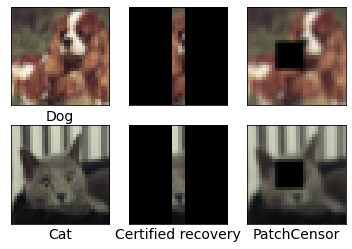

In [39]:
fig, ax_list = plt.subplots(2, 3, figsize=(6, 4))
ax_list[0][0].imshow(example_a.permute(1, 2, 0), cmap='gray')
ax_list[0][0].set_xticks([])
ax_list[0][0].set_yticks([])
ax_list[0][0].set_xlabel("Dog", fontsize=14)
ax_list[1][0].imshow(example_b.permute(1, 2, 0), cmap='gray')
ax_list[1][0].set_xticks([])
ax_list[1][0].set_yticks([])
ax_list[1][0].set_xlabel("Cat", fontsize=14)

mask_example_9 = torch.zeros_like(example_a)
mask_example_9[:, :, pos:pos+block_size] = example_a[:, :, pos:pos+block_size]
mask_example_b = torch.zeros_like(example_b)
mask_example_b[:, :, pos:pos+block_size] = example_b[:, :, pos:pos+block_size]
ax_list[0][1].imshow(mask_example_9.permute(1, 2, 0), cmap='gray')
ax_list[0][1].set_xticks([])
ax_list[0][1].set_yticks([])
#ax_list[0][1].axis('off')
ax_list[1][1].imshow(mask_example_b.permute(1, 2, 0), cmap='gray')
ax_list[1][1].set_xticks([])
ax_list[1][1].set_yticks([])
ax_list[1][1].set_xlabel("Certified recovery", fontsize=14)

batch_img = example_a.repeat(attn_mask.size(0), 1, 1, 1)
img_1 = transform2(transform1(batch_img[60]).masked_fill(img_mask == 0, 0.)[60])
ax_list[0][2].imshow(img_1.permute(1, 2, 0), cmap='gray')
ax_list[0][2].set_xticks([])
ax_list[0][2].set_yticks([])
batch_img = example_b.repeat(attn_mask.size(0), 1, 1, 1)
img_2 = transform2(transform1(batch_img[60]).masked_fill(img_mask == 0, 0.)[60])
ax_list[1][2].imshow(img_2.permute(1, 2, 0), cmap='gray')
ax_list[1][2].set_xticks([])
ax_list[1][2].set_yticks([])
ax_list[1][2].set_xlabel("PatchCensor", fontsize=14)
fig.savefig("discussion_pieces.pdf", dpi=300, bbox_inches='tight')

In [793]:
temp = torch.load("../error/img.pt")

In [794]:
original_preds = torch.load("../error/original_preds.pt")

In [795]:
new_preds = torch.load("../error/adv_preds.pt")

In [798]:
torch.unique(new_preds.cpu(), return_counts=True)

(tensor([36]), tensor([122]))

In [799]:
torch.unique(original_preds.cpu(), return_counts=True)

(tensor([35, 36]), tensor([69, 53]))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


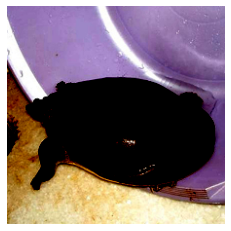

In [800]:
plt.imshow(temp[0][0].permute(1, 2, 0))
plt.axis('off')
plt.savefig("appendix_original.pdf", dpi=300)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


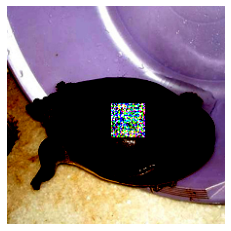

In [801]:
plt.imshow(temp[1][0].permute(1, 2, 0))
plt.axis('off')
plt.savefig("appendix_attacked.pdf", dpi=300)